In [19]:
import pandas as pd
import numpy as np
import glob
import os
import shutil
from datetime import datetime as dt
from scipy.stats import mode
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, log_loss
from sklearn.model_selection import train_test_split
from datetime import timedelta
from collections import Counter


# Prepare Test Data

In [20]:
df = pd.read_csv(r'tes data\telunjuk kanan 1m-2025-10-08.csv')
# gelang = pd.read_csv(r'tes data\gelang kanan 1m - 2025-10-08.csv')
df

,#!,Workbook:,Custom,Custom.1
0,#!,To play this data back: Open the original Exce...,NaN,NaN
1,#!,For more information visit http://aka.ms/hacki...,NaN,NaN
2,117014,NaN,NaN,NaN
3,117122,NaN,NaN,NaN
4,117346,NaN,NaN,NaN
...,...,...,...,...
910,119488,NaN,NaN,NaN
911,119193,NaN,NaN,NaN
912,118302,NaN,NaN,NaN
913,118485,NaN,NaN,NaN


In [21]:
df.dropna(axis=1, inplace=True)
df.drop(index=[0, 1, 2], inplace=True)
df.rename(columns={'#!':'ppg'}, inplace=True)
df.reset_index(drop=True, inplace=True)
df

,ppg
0,117122
1,117346
2,117651
3,117918
4,118046
...,...
907,119488
908,119193
909,118302
910,118485


In [22]:
scaler = MinMaxScaler()
scaler.fit(df)

df = scaler.transform(df)
df = pd.DataFrame(df)
df

,0
0,0.282372
1,0.327551
2,0.389068
3,0.442921
4,0.468737
...,...
907,0.759580
908,0.700081
909,0.520371
910,0.557281


In [23]:
print(len(df))
n_windows = len(df) // 125
n_windows

912


7

In [24]:
df

,0
0,0.282372
1,0.327551
2,0.389068
3,0.442921
4,0.468737
...,...
907,0.759580
908,0.700081
909,0.520371
910,0.557281


In [25]:
sampling_rate = 12
window_size = sampling_rate
ppg_signal = df.iloc[:, 0].values
n_windows = len(ppg_signal) // window_size

telunjuk_windows = []
for i in range(n_windows):
    start = i * window_size
    end = start + window_size
    window = ppg_signal[start:end]
    telunjuk_windows.append(window)

x = pd.DataFrame(telunjuk_windows)
x

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.282372,0.327551,0.389068,0.442921,0.468737,0.307987,0.176079,0.211981,0.251714,0.283784,0.346914,0.422549
1,0.477007,0.366680,0.201896,0.269867,0.348931,0.374344,0.419726,0.466317,0.515127,0.367285,0.201493,0.262606
2,0.332997,0.341670,0.362646,0.405809,0.374748,0.124445,0.123235,0.232957,0.252319,0.275313,0.336829,0.398346
3,0.246067,0.047196,0.110932,0.177491,0.191408,0.236789,0.301331,0.311214,0.067366,0.040339,0.137152,0.175272
4,0.221864,0.286608,0.360831,0.337434,0.100645,0.112142,0.190803,0.215208,0.261597,0.320089,0.381404,0.336023
...,...,...,...,...,...,...,...,...,...,...,...,...
71,0.532271,0.576240,0.644010,0.698265,0.745462,0.634127,0.383824,0.397539,0.463292,0.495966,0.525615,0.587939
72,0.646027,0.706333,0.705325,0.431222,0.394917,0.472570,0.511497,0.532473,0.583905,0.638967,0.689391,0.561517
73,0.349133,0.393505,0.472973,0.483461,0.516539,0.574829,0.631101,0.593183,0.309601,0.299718,0.380597,0.461678
74,0.520976,0.602662,0.667608,0.701493,0.495361,0.411860,0.474788,0.561113,0.614562,0.673255,0.737394,0.787414


In [26]:
sample = df.rename(columns={0:'ppg'})
print(len(sample))
sample

912


,ppg
0,0.282372
1,0.327551
2,0.389068
3,0.442921
4,0.468737
...,...
907,0.759580
908,0.700081
909,0.520371
910,0.557281


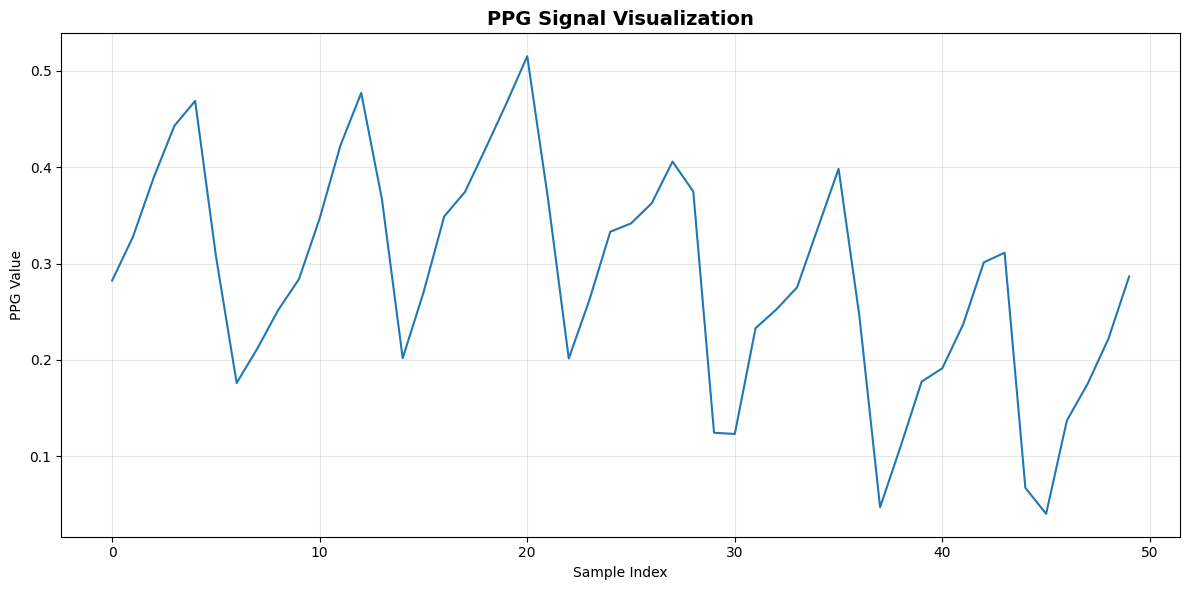

In [27]:
start, stop = 0, 50
wave = sample['ppg'].iloc[start:stop]
plt.figure(figsize=(12, 6))
plt.plot(range(len(wave)), wave)
plt.title('PPG Signal Visualization', fontsize=14, fontweight='bold')
plt.xlabel('Sample Index')
plt.ylabel('PPG Value')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Predict Test Data - Moment of Truth

In [28]:
best_model_file = r'models\model_05102025_225139.h5'
model = load_model(best_model_file)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [29]:
# Predict
y_pred_prob = model.predict(x).ravel()
y_pred = (y_pred_prob >= 0.5).astype(int)
print(y_pred_prob)
print(y_pred)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 266ms/step
[0.4092178  0.4739817  0.32042134 0.40287068 0.36604163 0.44441348
 0.31905466 0.38160318 0.48044562 0.47332388 0.45194796 0.41142625
 0.45666283 0.46043873 0.4574129  0.5062158  0.4469608  0.5319438
 0.30187434 0.39610562 0.35734844 0.37371472 0.43040776 0.3654528
 0.37312552 0.3675858  0.4004879  0.38346145 0.49089792 0.48412222
 0.38361084 0.4657238  0.43792832 0.51133835 0.49792856 0.52532256
 0.4496807  0.45484427 0.36915708 0.41493586 0.48579854 0.47743124
 0.44708875 0.42919448 0.41843936 0.5100068  0.4132712  0.45131555
 0.4522966  0.45353946 0.4170682  0.4841777  0.45913783 0.45315686
 0.38177583 0.3256346  0.2828719  0.3804126  0.31693494 0.23093164
 0.24179077 0.24962233 0.2664228  0.25537726 0.3158719  0.3087696
 0.430223   0.42093575 0.48110402 0.4618476  0.4350908  0.4856692
 0.45517004 0.44559774 0.49846342 0.45493242]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0

oh bentar. itu inputnya cuman jadi 7 window, padahal itukan 60 detik

In [30]:
y_true = [0] * len(x)
y_true

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [31]:
# Eval metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f'Accuracy: {acc:.4f}')
print(f"Precision: {prec:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")

Accuracy: 0.9342
Precision: 0.0000
Recall   : 0.0000
F1 Score : 0.0000


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [32]:
# roc auc
# roauc = roc_auc_score(y_true, y_pred_prob)
# print(f"ROC AUC  : {roauc:.4f}")
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.93      0.97        76
           1       0.00      0.00      0.00         0

    accuracy                           0.93        76
   macro avg       0.50      0.47      0.48        76
weighted avg       1.00      0.93      0.97        76



c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

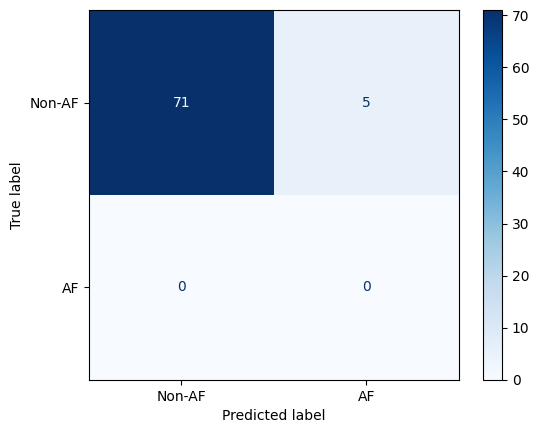

In [33]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-AF', 'AF'])
disp_cm.plot(cmap='Blues')